In [4]:
import sys
from typing import Iterable

import pydantic
from typing import Union
try:
    import micropip
    await micropip.install("matplotlib") 
except ModuleNotFoundError:
    pass


from local_lib.misc import custom_markdown_style
from local_lib.base import Etagère, Liste, VIDE
custom_markdown_style()

In [ ]:
sys.setrecursionlimit(15_000)

# Introduction

> Deux amis de longue date, Bric et Brac, ont ouvert deux magasins concurrente.
> 
> Bric dispose d'une grande étagère, qui permet de ranger chaque object dans un emplacement dédié.
>
> De son coté, Brac a ouvert son magasin au dessus d'un grand trou, qu'il compte utiliser pour stocker ses marchandises. Il a mis au point un système de boites, chaque boite étant reliée à la boite précédente par un crochet

<table> 
<tr>
    <th>Étagère de Bric</th>
    <th>Système de Brac</th>
</tr>

<tr>
    <td>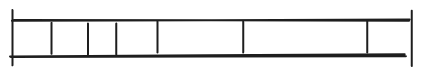</td>
    <td>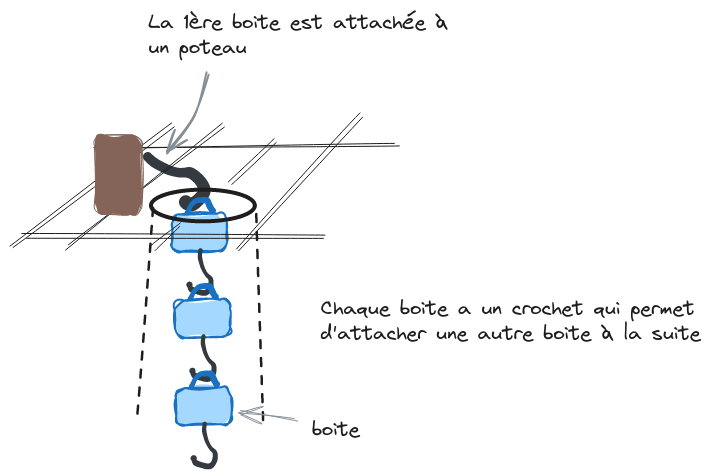</td>
</tr>

</table>


<!-- 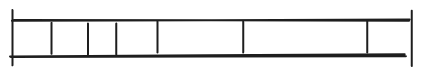 -->
<!-- 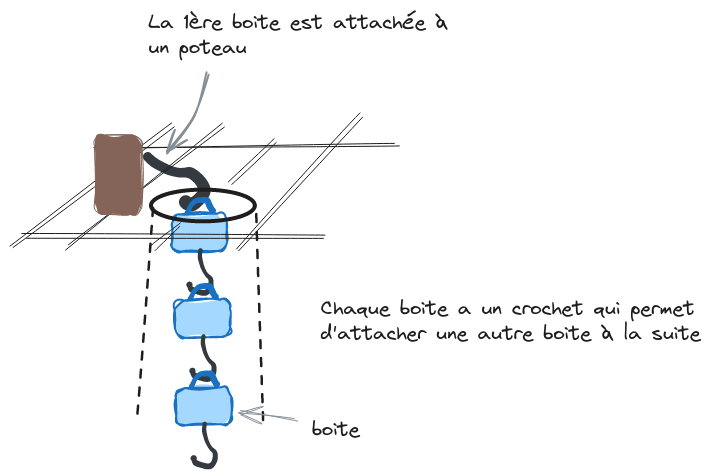 -->

Dans ce TD, nous allons étudier différentes stratégies de rangement de marchandises.

Pour ce faire, nous allons définir des structures de données très simples. Le but est de manipuler et d'étudier ces structures de données, afin de nous permettre faire d'obtenir les propriétés désirées en terme de:

- utilisation CPU (i.e. temps de calcul)
- utilisation mémoire (i.e. quantité de RAM utilisée)


Note: on utilisera des chaînes de caractère pour représenter les objets stockés.
# Magasin de Bric

## Étagère

<div style="float: right">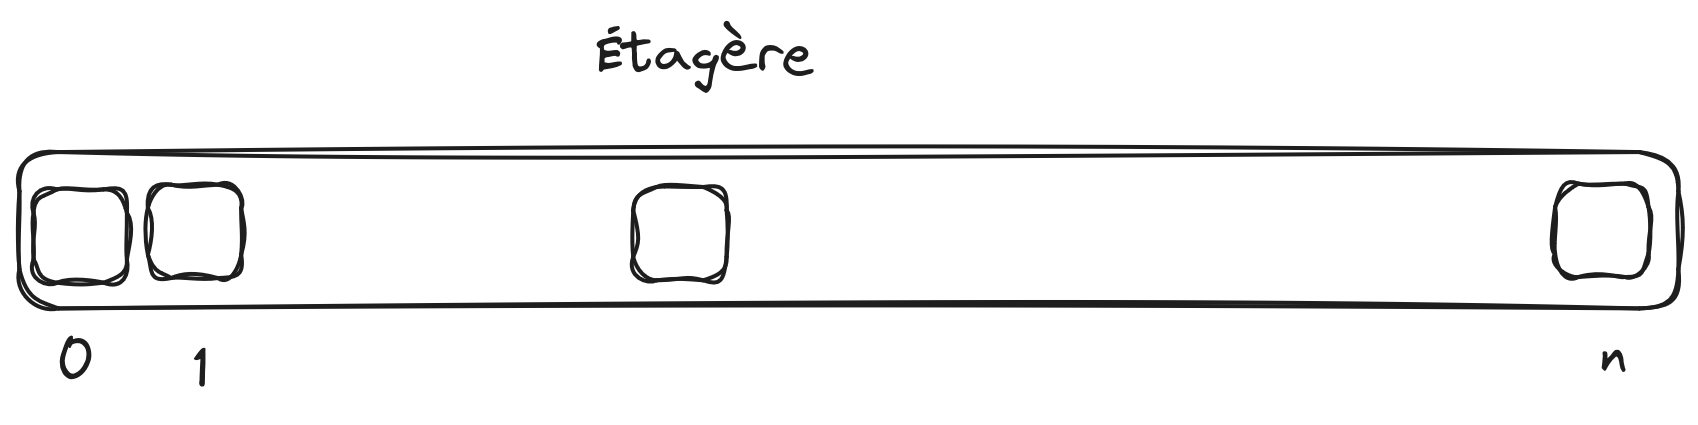</div>

<!-- 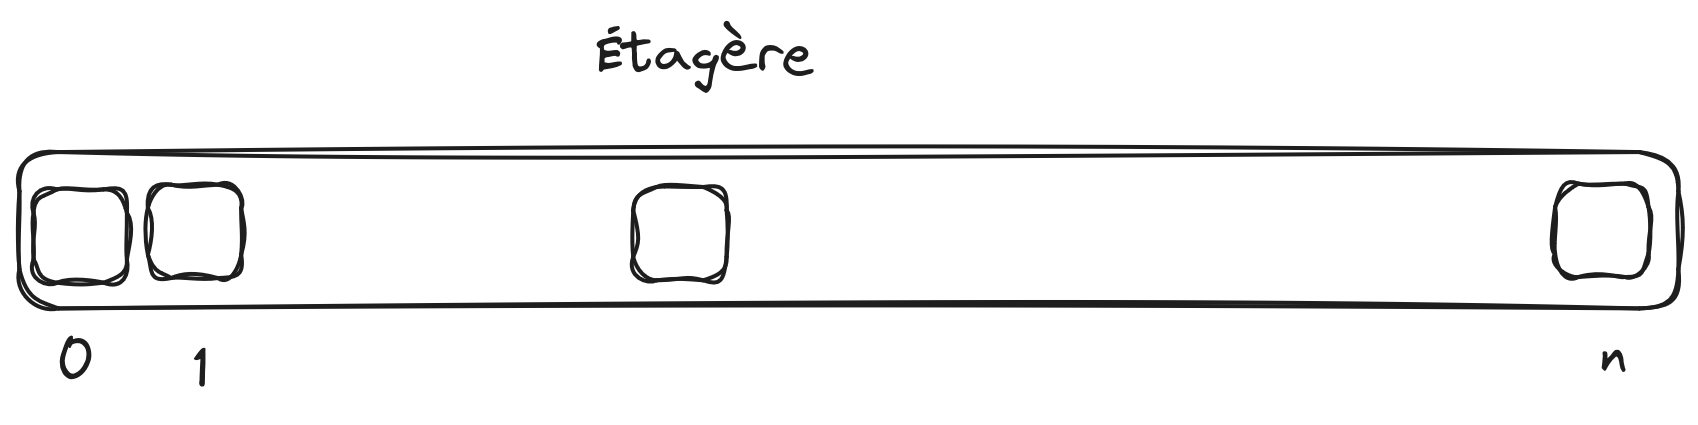 -->

Une étagère permet de ranger des éléments, et à accéder à chacun d'entre eux immédiatement.

Une fois qu'une étagère a été construite, on ne peut plus modifier sa taille.

**Note:** on utilisera la valeur `None` pour désigner un emplacement vide.

In [ ]:
# Instantiation: on crée une étagère avec 5 emplacements
a = Etagère(5)
a

In [ ]:
# accès à un élément
print(a[3])

In [ ]:
# Modification d'un élément
a[3] = 2
a[3]

In [ ]:
a

## Magasin avec étagère

Bric emploie une méthode simple pour ranger sa marchandise: à chaque fois qu'il reçoit un nouvel objet, il le range au premier emplacement vide.

Lorsque l'étagère est pleine, il la remplace par une nouvelle étagère, deux fois plus grande (en déplaçant bien sûr les objets.

### Exercice

Enrichir la classe Étagère avec les méthodes suivantes, afin de permettre à Bric de l'utiliser comme magasin:

In [ ]:
class Bric:
    def __init__(self, capacité=2):
        self.capacité = capacité
        self.eta = Etagère(capacité=self.capacité)
        
    def __getitem__(self, index):
        return self.eta[index]
    def __setitem__(self, index, value):
        self.eta[index] = value
    def _repr_html_(self):
        return self.eta._repr_html_()
        
    def nb_items(self) -> int:
        """Nombre d'éléments du tableau qui ne sont pas None"""
        #BEGIN
        res : int = 0
        for i in range(self.capacité):
            if self[i] is not None:
                res += 1
        return res
        #END

    def _remplace_étagère(self):
        """
        Remplace l'étagère actuelle par une nouvelle deux fois plus grande, 
        en gardant les objets stoqués
        """
        #BEGIN
        new_capa = self.capacité * 2
        new_eta = Etagère(capacité=new_capa)
        for i in range(self.capacité):
            new_eta[i] = self.eta[i]
        self.eta = new_eta
        self.capacité = new_capa
        #END
    
    def add(self, value: str):
        """
        Ajoute value dans la première case libre du tableau
        Si plus de place, crée une nouvelle étagère avec le double de capacité, puis place 
        la valeur dans une case vide.
        """
        #BEGIN
        for i in range(self.capacité):
            if self[i] is None:
                self[i] = value
                return
        self._remplace_étagère()
        self[i + 1] = value
        #END

    def remove(self, value):
        """
        Supprime la première case égale à value
        Lève une exception si pas trouvée
        """
        #BEGIN
        for i in range(self.capacité):
            if self.eta[i] == value:
                self.eta[i] = None
                return
        raise Exception("Pas trouvé")
        #END

    def contains(self, value) -> bool:
        """
        Teste si value fait partie des valeurs présentes
        """
        #BEGIN
        for i in range(self.capacité):
            if self.eta[i] == value:
                return True
        return False
        #END

    @staticmethod
    def from_values(
        values,
    ):
        res = Bric()
        for i, value in enumerate(values):
            res.add(value)
        return res

### Vérifications

Si les méthodes ci-dessus sont implémentées correctement, le cellules ci-dessous doivent s'exécuter sans erreur (et sans modifications)

**Note:** En cas de problème, ne pas hésiter à créer de nouvelles cellules de code pour débugger

In [ ]:
lbric = Bric.from_values(values=["aaa", "avx"])

assert (
    lbric[0] == "aaa"
    and lbric[1] == "avx" 
)
assert lbric.nb_items() == 2
lbric

In [ ]:
lbric = Bric.from_values(values=["aaa", "avx"])
print("On insère 'cde' dans le magasin")
lbric.add("cde")

assert lbric[2] == "cde"
assert lbric[3] == None
assert lbric.nb_items() == 3

lbric

In [ ]:
lbric = Bric.from_values(values=["aaa", "avx", "xyz"])
print("On supprime avx du magasin")
lbric.remove("avx")

assert lbric[1] is None
assert lbric.nb_items() == 2

assert lbric.contains("aaa")
assert not lbric.contains("avx")

lbric

# Magasin de Brac

## Liste chaînée

Pour modéliser le magasin de Brac, nous allons utiliser une structure de données appelée *"Liste chaînée"*.

Une liste chaînée est constitée:
- soit de la liste vide
- soit d'un élément contenant une valeur, et rattaché à une autre liste

*Exemples*:
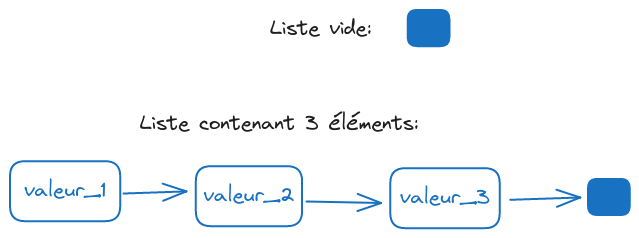

### Implémentation

On implémente ici une liste chaînée de la façon suivante:

On déclare une classe List contenant deux champs:
- `value`: contient la valeur de l'élément
- `next`: pointeur vers la liste suivante (qui peut être vide)

Si `value` est `None`, on considère que la liste est vide (dans ce cas, `next` doit aussi valoir `None`.


### Exemples d'utilisation



In [ ]:
# Liste vide
Liste()

In [ ]:
# Liste avec un élément
Liste("a", VIDE)

In [ ]:
# Liste avec un élément - alternative
Liste("dentifrice")

In [ ]:
# Liste avec plusieurs éléments
Liste(
    "dentifrice", 
         Liste("Brosse à dent"))

On pourra utiliser l'objet VIDE, et l'opérateur `+` pour créer facilement des listes:

**Note:** attention aux parenthèses !

In [ ]:
(3 + VIDE)

In [ ]:
2 + (3 + VIDE)

In [ ]:
2 + (3 + VIDE) == 2 + (3 + VIDE)

## Manipulation d'une liste chaînée

### Exercices de base

In [ ]:
# créer une liste
"a" + VIDE

### Exemple: longueur d'une liste

Nous allons présenter deux méthodes pour calculer la longueur d'une liste


In [ ]:
# Méthode avec boucle while

def longueur_while(liste: Liste):
    current_len = 0
    while not liste.is_empty():
        current_len += 1
        liste = liste.next
    return current_len

In [ ]:
print(longueur_while( VIDE))
print(longueur_while( "a" + VIDE))
print(longueur_while( "c" + ("b" + ("a" + VIDE))))

In [ ]:
# Méthode avec fonction récursive

def longueur_recursive(liste: Liste):
    if liste.is_empty():
        return 0
    else:
        return 1 + longueur_recursive(liste.next)

In [ ]:
print(longueur_recursive( VIDE))
print(longueur_recursive( "a" + VIDE))
print(longueur_recursive( "c" + ("b" + ("a" + VIDE))))

### Exercices

Implémenter les fonctions suivantes.


In [ ]:
def get_head(liste: Liste) -> str | None:
    """Retourne la première valeur de la liste (ou None si la liste est vide)"""
    #BEGIN
    if liste.is_empty():
        return None
    return liste.value
    #END

In [ ]:
assert get_head("a" + VIDE) == "a"
assert get_head(VIDE) == None

In [ ]:
def get_nth(liste: Liste, n: int) -> str | None:
    """Retourne la n-ème  valeur de la liste (ou None si la liste ne contient pas de n-ème élément)"""
    #BEGIN
    if liste.is_empty():
        return None
    if n == 0:
        return liste.value
    return get_nth(liste.next, n - 1)
    #END

In [ ]:
assert get_nth("c" + ("b" + ("a" + VIDE)), 0) == "c"
assert get_nth("c" + ("b" + ("a" + VIDE)), 1) == "b"
assert get_nth("c" + ("b" + ("a" + VIDE)), 2) == "a"
assert get_nth("c" + ("b" + ("a" + VIDE)), 3) == None

In [ ]:
def insert_back(liste: Liste, value: str) -> Liste:
    """Retourne une liste où value a été ajoutée à la fin"""
    #BEGIN
    if liste.is_empty():
        return Liste(value)
    else:
        return Liste(liste.value, next=insert_back(liste.next, value))
    #END
insert_back((1 + VIDE), 3)

In [ ]:
assert insert_back(
    "c" + ("b" + ("a" + VIDE)),
    "z") == "c" + ("b" + ("a" + ("z" + VIDE)))

In [ ]:
def contains(liste: Liste, value: str):
    """Teste si la liste contient value"""
    #BEGIN
    if liste.is_empty():
        return False
    if liste.value == value:
        return True
    return contains(liste.next, value)
    #END

In [ ]:
assert contains(
    "c" + ("b" + ("a" + ("z" + VIDE))),
    "b") is True
assert contains(
    "c" + ("b" + ("a" + ("z" + VIDE))),
    "x") is False

In [ ]:
def remove(liste: Liste, value: str) -> Liste:
    """Retourne une liste où value a été enlevée"""
    #BEGIN
    if liste.is_empty():
        raise Exception("Pas trouvé")
    if liste.value == value:
        return liste.next
    return Liste(liste.value, remove(liste.next, value))
    #END

In [ ]:
assert remove("a" + VIDE, "a") == VIDE
assert remove("b" + ("a" + VIDE), "a") == "b" + VIDE

## Magasin avec liste 

On peut maintenant implémenter le magasin de Brac, qui fonctionne avec une liste:

In [ ]:
class Brac:
    def __init__(self):
        self.list = Liste()
        
    def _repr_html_(self):
        return self.list._repr_html_()
    
    def nb_elements(self):
        return longueur_recursive(self.list)

    def add(self, value: str):
        self.list = value + self.list

    def remove(self, value):
        self.list = remove(self.list, value)
    
    def contains(self, value):
        return contains(self.list, value)
    
    @staticmethod
    def from_values(
        values
    ):
        res = Brac()
        for i, value in enumerate(values):
            res.add(value)
        return res

In [ ]:
b = Brac()
b.add("a")
display(b)
b.add("b")
display(b)
b.add("c")
display(b)
b.nb_elements()

In [ ]:
try:
    b.remove("d")
    b
except Exception as exc:
    display(exc)

In [ ]:
b.remove("a")
b

# Benchmark

On va ici comparer le temps d'insertion, et le temps de recherche, sur des tableaux ou des listes de taille similaire.

In [ ]:
import time
import random
import string

def random_name(length: int):
    return "".join(random.choice(string.ascii_letters) for _ in range(length))


all_books = [random_name(10) for _ in range(10_000)]
to_insert = [random_name(10) for _ in range(100)]
to_search = [random_name(10) for _ in range(100)]

In [ ]:
def benchmark_add(Klass, nb_items: int):
    magasin = Klass.from_values(all_books[0:nb_items])
    
    start_time = time.perf_counter()
    for value in to_insert:
        magasin.add(value)
    end_time = time.perf_counter()

    print(f"({nb_items}, {end_time - start_time}), # insertion {Klass.__name__}")
    return nb_items, end_time - start_time

def benchmark_contains(Klass, nb_items: int):
    magasin = Klass.from_values( all_books[0:nb_items])

    start_time = time.perf_counter()
    for value in to_search:
        magasin.contains(value)
    end_time = time.perf_counter()

    print(f"({nb_items}, {end_time - start_time}), # recherche {Klass.__name__}")
    return nb_items, end_time - start_time

In [ ]:

affiche_valeurs(
    titre="Temps pour 100 insertions",
    array=(
        benchmark_add(Bric, nb_items=1000),
        benchmark_add(Bric, nb_items=2000),
        benchmark_add(Bric, nb_items=5000),
        benchmark_add(Bric, nb_items=10000)
    ),
    liste=(
        benchmark_add(Brac, 1000),
        benchmark_add(Brac, 2000),
        benchmark_add(Brac, 5000),
        benchmark_add(Brac, 10000)
    )
)

## Exercice - Temps d'insertion

1. Décrire les courbes ci-dessus. Comment se comparent-elles ?
2. Comment expliquer cela ?

In [ ]:
affiche_valeurs(
    titre="Temps pour 100 recherches",
    array=(
        benchmark_contains(Bric, nb_items=1000),
        benchmark_contains(Bric, nb_items=2000),
        benchmark_contains(Bric, nb_items=5000),
        benchmark_contains(Bric, nb_items=10000),
    ),
    liste=(
        benchmark_contains(Brac, nb_items=1000),
        benchmark_contains(Brac, nb_items=2000),
        benchmark_contains(Brac, nb_items=5000),
        benchmark_contains(Brac, nb_items=10000)
    )
)

## Exercice - Temps de recherche

1. Décrire les courbes ci-dessus. Comment se comparent-elles ?
2. Comment expliquer cela ?

## Exercice - Conclusion

On suppose que Bric et Brac ont chacun autant d'objets à vendre. À chaque fois qu'un objet est vendu, il est remplacé par un nouvel objet. De plus, pour chaque client qui achète un objet, neuf autres clients demandent à voir un objet, mais ne l'achètent pas.

Lequel des deux vendeurs, Bric ou Brac, passera le plus de temps à travailler ?